In [1]:
%matplotlib inline

In [2]:
import re
import itertools

import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [3]:
import nltk


from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pepi_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.neural_network import MLPClassifier 

In [5]:
english_stopwords = stopwords.words('english')

# Fake news detction

## Abstract

In this notebook we will gather and clean data, create a fake news classifier and compare it with two other implementations.

## Contents:

Introduction: [Introduction](#Introduction)

Terminologies: [Terminologies](#Terminologies)

Project: [Project](#Project)

Testing our model on different data: [Testing our model on different data](#Testing-our-model-on-different-data)

## Introduction

We consume news through several mediums throughout the day in our daily routine, but sometimes it becomes difficult to decide which one is fake and which one is authentic.

Do you trust all the news you consume from online media?

Every news that we consume is not real. If you listen to fake news it means you are collecting the wrong information from the world which can affect society because a person’s views or thoughts can change after consuming fake news which the user perceives to be true.

Since all the news we encounter in our day-to-day life is not authentic, how do we categorize if the news is fake or real?

In this notebook, we will focus on text-based news and try to build a model that will help us to identify if a piece of given news is fake or real.

Before moving to the practical things let’s get aware of few terminologies.

## Terminologies

### Fake News

A sort of sensationalist reporting, counterfeit news embodies bits of information that might be lies and is, for the most part, spread through web-based media and other online media.

This is regularly done to further or force certain kinds of thoughts or for false promotion of products and is frequently accomplished with political plans.

Such news things may contain bogus and additionally misrepresented cases and may wind up being virtualized by calculations, and clients may wind up in a channel bubble.

### TF-IDF Vectorizer

**TF (Term Frequency)**:  In the document, words are present so many times that is called term frequency. In this section, if you get the largest values it means that word is present so many times with respect to other words. when you get word is parts of speech word that means the document is a very nice match.

**IDF (Inverse Document Frequency)**: in a single document, words are present so many times, but also available so many times in another document also which is not relevant. IDF is a proportion of how critical a term is in the whole corpus.

### Confusion Matrix

The confusion matrix is a matrix used to determine the performance of the classification models for a given set of test data. It can only be determined if the true values for test data are known. The matrix itself can be easily understood, but the related terminologies may be confusing. Since it shows the errors in the model performance in the form of a matrix, hence also known as an error matrix. Some features of Confusion matrix are given below:

* The confusion matrix is an $ n * n $ matrix, where $ n $ is the count of classifier classes. In our case $ n $ is equal to 2 (we have two classes: fake and real news), so the confusion matrix will be a $ 2 * 2 $ matrix

* The matrix is divided into two dimensions, that are predicted values and actual values along with the total number of predictions.

* Predicted values are those values, which are predicted by the model, and actual values are the true values for the given observations.

* A $ 2 * 2 $ confusion matrix looks like below:

![Confusion matrix](images/confusion-matrix.jpeg)

Source: [https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5](https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5)


Note: Type 1 error is called false positive and type 2 error is called false negative.

## Project

To get the accurately classified collection of news as real or fake we have to build a machine learning model.

To deals with the detection of fake or real news, we will develop the project in python with the help of "sklearn", we will use "TfidfVectorizer" in our news data which we will gather from online media.

After the first step is done, we will initialize the classifier, transform and fit the model. In the end, we will calculate the performance of the model using the appropriate performance matrix/matrices. Once will calculate the performance matrices we will be able to see how well our model performs.

The practical implementation of these tools is very simple and will be explained step by step in this notebook.

Let's start.

### Data preparation

Let's start by reading our train dataset, which is done below.

In [6]:
train_news = pd.read_csv('data/fake-news/train.csv')

Now let's see how our data looks like by getting the first 5 rows.

In [7]:
train_news.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


The label column tells us if a news is real or fake. 1 means fake news, 0 means real news.

Now we will see the columns types.

In [8]:
train_news.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

After that let's see how many observations (rows) and features (columns) we have.

In [9]:
train_news.shape

(20800, 5)

We can see that we have 20800 observations on 5 features. One of those features is id which we will set as index.

In [10]:
train_news = train_news.set_index("id")

In [11]:
train_news.shape

(20800, 4)

We now have 4 features which are title, author, text and label, because we set id as an index.

Next thing we will do is to check if we have missing values.

In [12]:
train_news.isna().any()

title      True
author     True
text       True
label     False
dtype: bool

We see that we have missing values at every column except label. Since the missing values are only on text columns we can fill them with empty string.

In [13]:
train_news = train_news.fillna(value = {"title": "", "author": "", "text": ""})

In [14]:
train_news.shape

(20800, 4)

After we fixed missing values, we will see if we have any duplicated values.

In [15]:
train_news.duplicated().any()

True

We have duplicated values. Let's drop them.

In [16]:
train_news = train_news.drop_duplicates()

In [17]:
train_news.shape

(20691, 4)

We now have 20691 observations. The row drops are done to improve model performance. After we cleaned our data we can plot a histogram to see the distribution of news in train dataset.

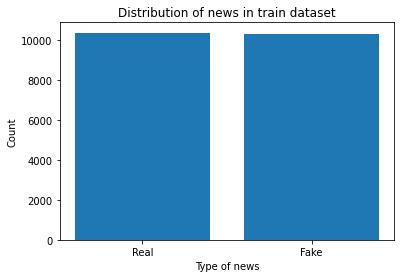

In [18]:
plt.bar(range(2), [len(train_news[train_news["label"] == 0]),len(train_news[train_news["label"] == 1])])

plt.title("Distribution of news in train dataset")

plt.xticks(range(2), ["Real", "Fake"])

plt.xlabel("Type of news")
plt.ylabel("Count")

plt.show()

Before we clean our test dataset we will add a `data` column that is the combination of `title` and `author` columns because it will improve model accuracy.

In [19]:
train_news["data"] = train_news["title"] + " " + train_news["author"]

Let's see if our dtypes are normal.

In [20]:
train_news.dtypes

title     object
author    object
text      object
label      int64
data      object
dtype: object

The types are normal but the columns are not ordered well. We will fix that

In [21]:
train_news = train_news[["title", "author", "text", "data", "label"]]

Now let's clean our test dataset.

In [22]:
test_news = pd.read_csv("data/fake-news/test.csv")

Below we can see how our test dataset looks like.

In [23]:
test_news.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


We can see we have no label column, which is right since this is a test dataset. The labels are in "fake-news/test-labels.csv"

Let's see how many observations and features we have.

In [24]:
test_news.shape # We have 5200 observations on 4 features

(5200, 4)

We will now see if we have any missing values.

In [25]:
test_news.isna().any()

id        False
title      True
author     True
text       True
dtype: bool

Now let's fix the missing values.

In [26]:
test_news = test_news.fillna(value = {"title": "", "author": "", "text": ""})

In [27]:
test_news.shape

(5200, 4)

Before we read our test labels we have to see if we have any duplicate values.

In [28]:
test_news.duplicated().any()

False

We have no duplicated values, which means we can proceed to test labels preparation.

In [29]:
test_labels = pd.read_csv("data/fake-news/test-labels.csv")

In [30]:
test_labels.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


Since we dropped values from test dataset we need to remove the rows related to the removed records.

In [31]:
test_labels["id"] = test_news["id"] 

# In this cell we set the ids of test labels to the ids of test news because it is easier to now drop rows with missing ids

In [32]:
test_labels = test_labels.dropna()

### Data analysis
In this section we will "get to know" our train data.

Firstly, we will create a wordcloud plot function.

In [33]:
def plot_wordcloud(data, title):
    wordcloud = WordCloud(
                        background_color='black',
                        stopwords=english_stopwords,
                        max_words=200, 
                        random_state=42).generate(str(data))

    plt.figure(figsize=(15,10))
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42))
    plt.show()

After that we will get statistics for our train dataset.

In [34]:
train_news.describe(include = "all")

,title,author,text,data,label
count,20691,20691,20691,20691,20691.000000
unique,19804,4202,20387,20412,NaN
top,,,,Anonymous,NaN
freq,518,1932,73,30,NaN
mean,NaN,NaN,NaN,NaN,0.497994
std,NaN,NaN,NaN,NaN,0.500008
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,1.000000


In the four cells below we filter all titles and texts that contaion the words `sensation` and `breitbart`

The first filter is for titles containing breitbart.

In [35]:
train_news_containing_breitbart_in_title_filter = train_news.title.str.lower().str.contains("breitbart")

train_news_containing_breitbart_in_title = train_news[train_news_containing_breitbart_in_title_filter]

train_news_containing_breitbart_in_title.head()

,title,author,text,data,label
id,,,,,
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",Jackie Mason: Hollywood Would Love Trump if He...,0
19,Chuck Todd: ’BuzzFeed Did Donald Trump a Polit...,Jeff Poor,Wednesday after Donald Trump’s press confere...,Chuck Todd: ’BuzzFeed Did Donald Trump a Polit...,0
22,Rob Reiner: Trump Is ’Mentally Unstable’ - Bre...,Pam Key,"Sunday on MSNBC’s “AM Joy,” actor and director...",Rob Reiner: Trump Is ’Mentally Unstable’ - Bre...,0
26,EXCLUSIVE: Islamic State Supporters Vow to ‘Sh...,Aaron Klein and Ali Waked,JERUSALEM — Islamic State sympathizers and ...,EXCLUSIVE: Islamic State Supporters Vow to ‘Sh...,0


We can see that all 5 initial values are real. This is interesting, we can see the labels.

In [36]:
train_news_containing_breitbart_in_title.label.value_counts()

0    2352
1       4
Name: label, dtype: int64

We see that from 2356 news 2353 are real. Next, we will see all news whose titles contain the word sensation.

In [37]:
train_news_containing_sensation_in_title_filter = train_news.title.str.lower().str.contains("sensation")

train_news_containing_sensation_in_title = train_news[train_news_containing_sensation_in_title_filter]

train_news_containing_sensation_in_title.head()

,title,author,text,data,label
id,,,,,
5225,"How a Sensational, Unverified Dossier Became a...","Scott Shane, Nicholas Confessore and Matthew R...","WASHINGTON — Seven months ago, a respected ...","How a Sensational, Unverified Dossier Became a...",0


We can see that only one piece of news contains the word sensation on title.

Next we will see all texts that contain sensation and breitbart. The first filter is for the breitbart word.

In [38]:
train_news_containing_breitbart_in_text_filter = train_news.text.str.lower().str.contains("breitbart")

train_news_containing_breitbart_in_text = train_news[train_news_containing_breitbart_in_text_filter]

train_news_containing_breitbart_in_text.head()

,title,author,text,data,label
id,,,,,
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",Jackie Mason: Hollywood Would Love Trump if He...,0
10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",Obama’s Organizing for Action Partners with So...,0
26,EXCLUSIVE: Islamic State Supporters Vow to ‘Sh...,Aaron Klein and Ali Waked,JERUSALEM — Islamic State sympathizers and ...,EXCLUSIVE: Islamic State Supporters Vow to ‘Sh...,0
37,Open Thread (NOT U.S. Election) 2016-39,b,Open Thread (NOT U.S. Election) 2016-39 \nNews...,Open Thread (NOT U.S. Election) 2016-39 b,1
38,Democrat Gutierrez Blames Chicago’s Gun Violen...,AWR Hawkins,Rep. Luis Gutierrez ( ) made the rounds on MS...,Democrat Gutierrez Blames Chicago’s Gun Violen...,0


In [39]:
train_news_containing_breitbart_in_text.label.value_counts()

0    1676
1     141
Name: label, dtype: int64

We can see again that most of the news that contain word breitbart are real.

In [40]:
train_news_containing_sensation_in_text_filter = train_news.text.str.lower().str.contains("sensation")

train_news_containing_sensation_in_text = train_news[train_news_containing_sensation_in_text_filter]

train_news_containing_sensation_in_text.head()

,title,author,text,data,label
id,,,,,
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,,Ever wonder how Britain’s most iconic pop pian...,Life: Life Of Luxury: Elton John’s 6 Favorite ...,1
59,Mindful Eating as Way to Fight Bingeing - The ...,Jeff Gordinier,Editors’ note: We’re resurfacing this 2012 art...,Mindful Eating as Way to Fight Bingeing - The ...,0
122,“Chapo Trap House”: New Left-Wing Podcast is a...,Eric Striker,“Chapo Trap House”: New Left-Wing Podcast is a...,“Chapo Trap House”: New Left-Wing Podcast is a...,1
523,The Pecan Steps Off the Pie Plate - The New Yo...,David Tanis,"Pecans, with their rich, buttery, sweet flavor...",The Pecan Steps Off the Pie Plate - The New Yo...,0
529,Comment on Gold Medalist Wrestler Gets Violent...,Buck Rogers,"USA CREATED ISIS ,ALL EUROPEAN KNOW ABOUT THAT...",Comment on Gold Medalist Wrestler Gets Violent...,1


In [41]:
train_news_containing_sensation_in_text.label.value_counts()

0    114
1     67
Name: label, dtype: int64

We notice that most of the news that contain sensation in text are real. Now let's see all the news with author Breitbart news.

In [42]:
breitbart_news = train_news[train_news.author == 'Breitbart News']

In [43]:
breitbart_news.head()

,title,author,text,data,label
id,,,,,
94,Breitbart News Daily: Trump Boom - Breitbart,Breitbart News,On the Thursday edition of Breitbart News Dail...,Breitbart News Daily: Trump Boom - Breitbart B...,0
340,Politico: Hillary Clinton Is Running Again - B...,Breitbart News,"Matt Latimer, a former Bush speechwriter and c...",Politico: Hillary Clinton Is Running Again - B...,0
746,Breitbart News Daily: Draining the Swamp - Bre...,Breitbart News,"On the Friday edition of Breitbart News Daily,...",Breitbart News Daily: Draining the Swamp - Bre...,0
1000,Breitbart News Daily: Gorsuch for SCOTUS - Bre...,Breitbart News,On the Wednesday edition of Breitbart News Dai...,Breitbart News Daily: Gorsuch for SCOTUS - Bre...,0
1396,Report: Tamron Hall Leaves NBC News over Megyn...,Breitbart News,Report claims that NBC anchor Tamron Hall turn...,Report: Tamron Hall Leaves NBC News over Megyn...,0


We see that 5 of the news are real. Let's get the value counts for labels.

In [44]:
breitbart_news.label.value_counts()

0    118
Name: label, dtype: int64

We see that all Breitbart news are real. We can say that Breitbart news is a credible source. Now, let's check Consortiumnews.com.

In [45]:
consortium_news = train_news[train_news.author == 'Consortiumnews.com']

In [46]:
consortium_news.head()

,title,author,text,data,label
id,,,,,
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...,1
194,Death of the ‘Two-State Solution’,Consortiumnews.com,"Death of the ‘Two-State Solution’ November 16,...",Death of the ‘Two-State Solution’ Consortiumne...,1
682,Breakdown of the Clinton Money Machine,Consortiumnews.com,Breakdown of the Clinton Money Machine Novembe...,Breakdown of the Clinton Money Machine Consort...,1
2023,Taking a Page from Joe McCarthy,Consortiumnews.com,"Taking a Page from Joe McCarthy November 1, 20...",Taking a Page from Joe McCarthy Consortiumnews...,1
2198,US Hypocrisy Over Russian ‘War Crimes’,Consortiumnews.com,US Hypocrisy Over Russian ‘War Crimes’ Novembe...,US Hypocrisy Over Russian ‘War Crimes’ Consort...,1


In [47]:
consortium_news.label.value_counts()

1    58
Name: label, dtype: int64

We see that all news from Consortiumnews.com are fake. We can say that Consortiumnews.com is not a credible source.

After that we will plot some wordclouds.

The first wordcloud is for texts of fake news.

In [48]:
fake_news = train_news[train_news.label == 1]

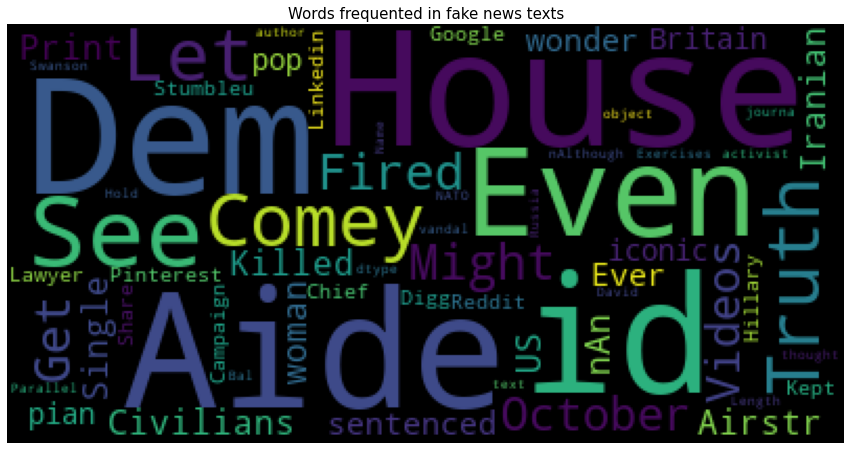

In [49]:
plot_wordcloud(fake_news["text"], "Words frequented in fake news texts")

The next wordcloud is for titles of fake news.

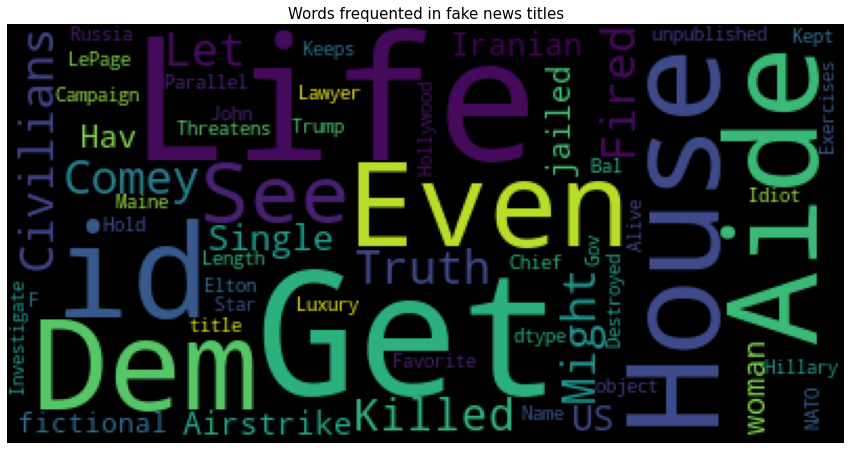

In [50]:
plot_wordcloud(fake_news["title"], "Words frequented in fake news titles")

The last two wordclouds are for texts and titles of real news.

In [51]:
real_news = train_news[train_news.label == 0]

The first wordcloud for real news is for texts.

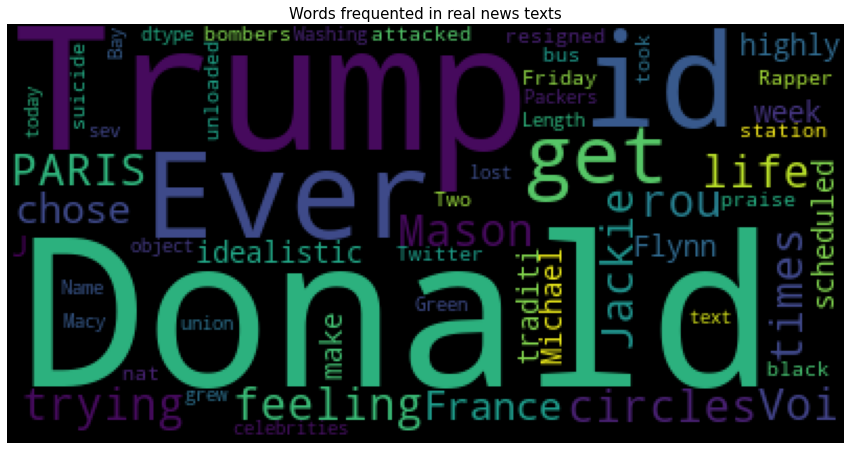

In [52]:
plot_wordcloud(real_news["text"], "Words frequented in real news texts")

The final wordcloud is for texts of real news.

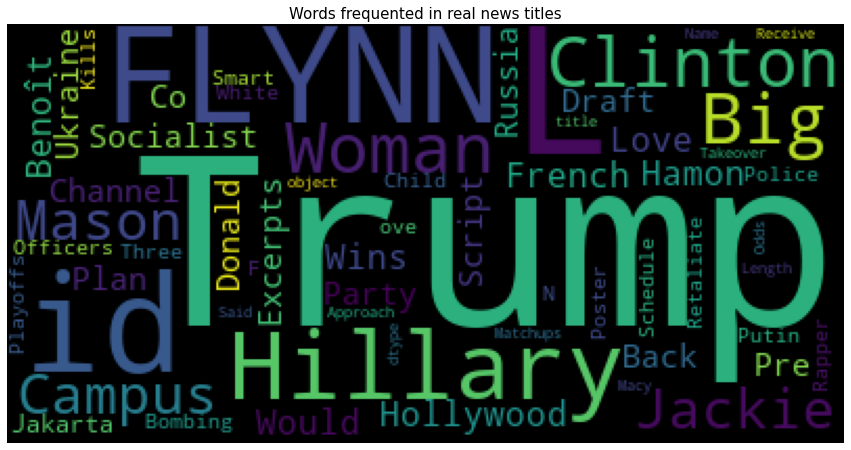

In [53]:
plot_wordcloud(real_news["title"], "Words frequented in real news titles")

Now we will try to find other factors than the words that determine whether news is real or fake. Let's start by creating a dataframe which includes title length and label of test news.

In [54]:
title_length_and_label = pd.DataFrame({"title_len": train_news.title.str.len(), "label": train_news.label})

After that we will see the most frequent labels for titles with length over and less 50 symbols.

In [55]:
titles_lens_more_than_50 = title_length_and_label[title_length_and_label.title_len > 50]

In [56]:
titles_lens_more_than_50.label.value_counts()

0    10028
1     7331
Name: label, dtype: int64

After we got the values for titles with lengths less than 50, let's see the titles, authors and labels.

In [57]:
train_news.loc[titles_lens_more_than_50.index][["title", "author", "label"]].head()

,title,author,label
id,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,0
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,1
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,0


In [58]:
titles_lens_less_than_50 = title_length_and_label[title_length_and_label.title_len < 50]

In [59]:
titles_lens_less_than_50.label.value_counts()

1    2855
0     302
Name: label, dtype: int64

After we got the values for titles with lengths more than 50, let's see their titles, authors and labels.

In [60]:
train_news.loc[titles_lens_less_than_50.index][["title", "author", "label"]].head()

,title,author,label
id,,,
2,Why the Truth Might Get You Fired,Consortiumnews.com,1
13,US Officials See No Link Between Trump and Russia,Jason Ditz,1
18,FBI Closes In On Hillary!,The Doc,1
37,Open Thread (NOT U.S. Election) 2016-39,b,1
41,4 of the Best Kinds of Milk That Aren’t Dairy,Alexandria Laredo,1


In [61]:
train_news.loc[titles_lens_less_than_50[titles_lens_less_than_50.label == 0].index].head()

,title,author,text,data,label
id,,,,,
94,Breitbart News Daily: Trump Boom - Breitbart,Breitbart News,On the Thursday edition of Breitbart News Dail...,Breitbart News Daily: Trump Boom - Breitbart B...,0
185,Work. Walk 5 Minutes. Work. - The New York Times,Gretchen Reynolds,Stuck at your work desk? Standing up and walki...,Work. Walk 5 Minutes. Work. - The New York Tim...,0
191,Mr. Trump’s Wild Ride - The New York Times,Robert Draper,‘Have you seen the latest polls? I’m beating H...,Mr. Trump’s Wild Ride - The New York Times Rob...,0
298,Iceland’s Water Cure - The New York Times,Dan Kois,"On a frigid February day in Reykjavik, I stood...",Iceland’s Water Cure - The New York Times Dan ...,0
451,The Jobs Americans Do - The New York Times,Binyamin Appelbaum,Forget the images of men in hard hats standing...,The Jobs Americans Do - The New York Times Bin...,0


We can see that the most of the titles with length over 50 symbols are real while most of the titles with length less than 50 symbols are fake.

After that, let's see distributions of lenghts of titles.

In [62]:
grouped_titles_by_len = title_length_and_label.sort_values('title_len', ascending=False)

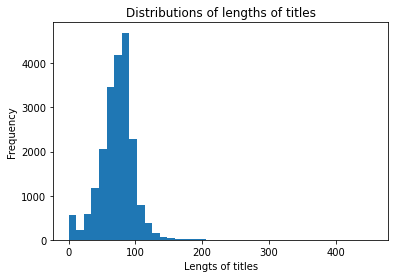

In [63]:
plt.hist(grouped_titles_by_len.title_len, bins = 40)

plt.xlabel('Lengts of titles')
plt.ylabel('Frequency')

plt.title('Distributions of lengths of titles')

plt.show()

After we analyzed the infromation from titles' lengths, let's analyze texts' lengths

In [64]:
text_length_and_label = pd.DataFrame({"text_len": train_news.text.str.len(), "label": train_news.label})

In [65]:
grouped_texts_by_len = text_length_and_label.sort_values('text_len', ascending=False)

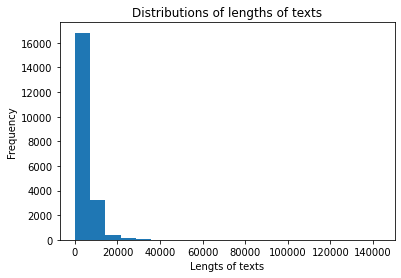

In [66]:
plt.hist(grouped_texts_by_len.text_len, bins = 20)

plt.xlabel('Lengts of texts')
plt.ylabel('Frequency')

plt.title('Distributions of lengths of texts')

plt.show()

Now let's choose lengths that we want to filter by. In our case we will choose less than 5k symbols and between 5k and 10k symbols.

Firstly, we will get all titles with lengths less than 5k and the corresponding news.

In [67]:
texts_lens_less_than_5k_filter = text_length_and_label.text_len < 5000

texts_lens_less_than_5k = text_length_and_label[texts_lens_less_than_5k_filter]

news_with_texts_lens_less_than_5k = train_news.loc[texts_lens_less_than_5k.index]

news_with_texts_lens_less_than_5k.head()

,title,author,text,data,label
id,,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...,1
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",Jackie Mason: Hollywood Would Love Trump if He...,0


In [68]:
news_with_texts_lens_less_than_5k.label.value_counts()

1    7862
0    5625
Name: label, dtype: int64

We can see that the counts of real and fake news have 2k difference in counts.

In [69]:
texts_lens_between_5k_and_10k_filter = (text_length_and_label.text_len > 5000) & (text_length_and_label.text_len <= 10000)

text_lens_between_5k_and_10k = text_length_and_label[texts_lens_between_5k_and_10k_filter]

news_with_texts_lens_between_5k_and_10k = train_news.loc[text_lens_between_5k_and_10k.index]

news_with_texts_lens_between_5k_and_10k.head()

,title,author,text,data,label
id,,,,,
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...,1
8,Excerpts From a Draft Script for Donald Trump’...,,Donald J. Trump is scheduled to make a highly ...,Excerpts From a Draft Script for Donald Trump’...,0
10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",Obama’s Organizing for Action Partners with So...,0
15,"In Major League Soccer, Argentines Find a Home...",Jack Williams,Guillermo Barros Schelotto was not the first A...,"In Major League Soccer, Argentines Find a Home...",0
16,Wells Fargo Chief Abruptly Steps Down - The Ne...,Michael Corkery and Stacy Cowley,The scandal engulfing Wells Fargo toppled its ...,Wells Fargo Chief Abruptly Steps Down - The Ne...,0


In [70]:
news_with_texts_lens_between_5k_and_10k.label.value_counts()

0    4115
1    1723
Name: label, dtype: int64

We can see that we have more real news with lengths between 5k and 10k than fake news.

Before we proceed to the next section we will generate a report with information for columns.

In [71]:
train_news.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Feature Extraction

Here we will work with a copy of train news because we do not want to modify the original dataset.

In [72]:
messages = train_news.copy()

Here we set the index to be default, not id column.

In [73]:
messages = messages.reset_index()

In [74]:
messages = messages[["data", "label"]]

In [75]:
messages.head()

,data,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired Consortiumne...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


Here we will stem all words that are not stopwords. Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form.

Note: This cell might need 1-2 minutes to execute because we apply a function on 21k records.

In [76]:
ps = PorterStemmer()

def stem(data):
    stemmed_content = re.sub('[^a-zA-Z]',' ',data)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words("english")]
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

messages["data"] = messages["data"].apply(stem)

### Classifier Implementation

The model will be implemented by using PassiveAgressive classifier. This classifier falls under the category of online learning in ML. Online learning models keep learning even after they are deployed to production. PassiveAgressive classifier remains passive if its predictions are correct and becomes agressive when it makes wrong predictions.

#### Confusion Matrix Plot Function

In this section we will create a confusion matrix plot function.

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Here we print the if confusion matrix is normalized
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Here we include text that shows confusion matrix values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#### Model Report Function

In this section we create a function that prints a classification report and plots confusion matrix.

In [78]:
def model_report(model, X_test, y_test):
    pred = model.predict(X_test)
    
    print(accuracy_score(y_test, pred) * 100)

    print(classification_report(y_test, pred))

    cm = confusion_matrix(y_test, pred)

    plot_confusion_matrix(cm, classes=['Fake News', 'Real News'])

#### The TF-IDF Vectorizer

Here we will define our TF-IDF vectorizer. We use vectorizer to convert our text data to a feature vector. Feature vectors are used widely in machine learning because of the effectiveness and practicality of representing objects in a numerical way to help with many kinds of analyses. They are good for analysis because there are many techniques for comparing feature vectors.

In [79]:
tfidf_v = TfidfVectorizer(max_features = 50000, ngram_range=(1,3))

Now we will pass it our corpus to fit and transform it.

In [80]:
X = tfidf_v.fit_transform(train_news["data"]).toarray()

#### Getting Train and Test Data

In this section, we will gather our train and test data.

Let's start by getting our labels, which is done below.

In [81]:
y = messages['label']

After that we have to split our data and labels in train and test.

The `random_state = 42` argument is to always get the same data.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y, random_state=42)

#### Creating the Model

In this section we will create our model in Python.

The row below creates the model. The argument `n_iter_no_change` is used to set the number of iterations with no improvement to wait before early stopping.

In [99]:
passive_agressive = BaggingClassifier(
    PassiveAggressiveClassifier(
       C=0.001,
       n_iter_no_change=1,
       early_stopping=True,
       tol = .3,
       loss = 'squared_hinge',
    ),
    n_estimators = 1,
    random_state = 42,
)

Here we fit our model, or learning it to classify fake news.

In [100]:
passive_agressive.fit(X_train, y_train)

PassiveAggressiveClassifier(early_stopping=True, n_iter_no_change=1)

Now let's test it. First we will get its accuracy on test data, which is pretty high. After that we will plot the confusion matrix of the model to see how many wrong values there are.

99.03381642512076
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1039
           1       0.99      0.99      0.99      1031

    accuracy                           0.99      2070
   macro avg       0.99      0.99      0.99      2070
weighted avg       0.99      0.99      0.99      2070

Confusion matrix, without normalization


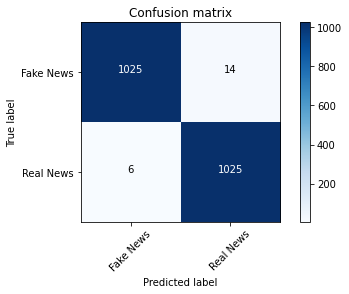

In [85]:
model_report(passive_agressive, X_test, y_test)

After we tested it on test data, we will test it on train data.

99.71537511411846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9348
           1       1.00      1.00      1.00      9273

    accuracy                           1.00     18621
   macro avg       1.00      1.00      1.00     18621
weighted avg       1.00      1.00      1.00     18621

Confusion matrix, without normalization


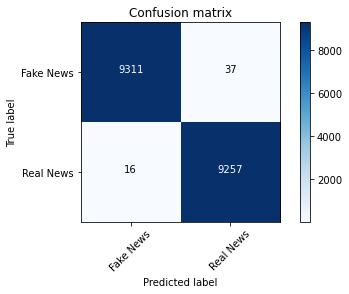

In [86]:
model_report(passive_agressive, X_train, y_train)

### Comprasions

In this section we will compare our implementation of fake news classifier with two other implementations.

#### Multinomial Naive Bayes

The first model we will compare with ours is Multinomial Naive Bayes. The Multinomial Naive Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance.

In [87]:
nb = MultinomialNB()

In [88]:
nb.fit(X_train, y_train)

MultinomialNB()

96.37681159420289
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1039
           1       0.99      0.93      0.96      1031

    accuracy                           0.96      2070
   macro avg       0.97      0.96      0.96      2070
weighted avg       0.97      0.96      0.96      2070

Confusion matrix, without normalization


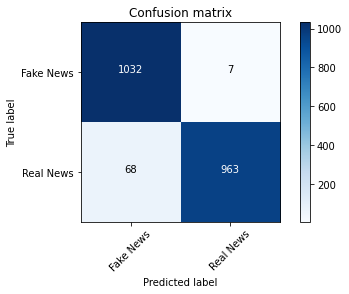

In [89]:
model_report(nb, X_test, y_test)

#### Logistic Regression

The second and last comprasion will be done with Logistic Regression. Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1.

In [90]:
logistic_regression = LogisticRegression()

In [91]:
logistic_regression.fit(X_train, y_train)

LogisticRegression()

97.92270531400966
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1039
           1       0.96      1.00      0.98      1031

    accuracy                           0.98      2070
   macro avg       0.98      0.98      0.98      2070
weighted avg       0.98      0.98      0.98      2070

Confusion matrix, without normalization


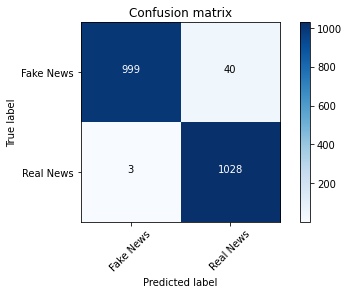

In [92]:
model_report(logistic_regression, X_test, y_test)

## Testing our model on different data

Before the conclusion I would like to test our model on different data (find the data source in the References).

### Processing data

In this section our additional data will be processed.

In [87]:
additional_data = pd.read_csv("data/fake_or_real_news.csv")

In [88]:
additional_data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


We see that we have an column with wrong name, so lets rename it.

In [89]:
additional_data = additional_data.rename(columns = {"Unnamed: 0": "id"})

Now we will check for missing values.

In [90]:
additional_data.isna().any()

id       False
title    False
text     False
label    False
dtype: bool

Let's see how are our news distibuted.

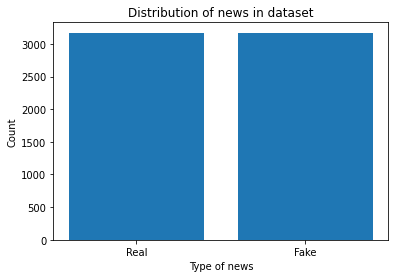

In [91]:
plt.bar(range(2), 
        [len(additional_data[additional_data["label"] == "REAL"]),
         len(additional_data[additional_data["label"] == "FAKE"])
])

plt.title("Distribution of news in dataset")

plt.xticks(range(2), ["Real", "Fake"])

plt.xlabel("Type of news")
plt.ylabel("Count")

plt.show()

### Testing the data on the model

In this section we will use our processed additional data to perfrom tests on our model.

Now we have to set our label column to numbers (0 and 1).

In [92]:
additional_data.label = additional_data.label.replace(["REAL", "FAKE"], [0, 1])

In [93]:
labels = additional_data.label

Now we need to use our stem function to prepare our additional data for TF-IDF Vectorizer.

In [94]:
additional_data["title"] = additional_data["title"].apply(stem)

Here we use new TF-IDF Vectorizer to convert our sample to feature vector.

In [95]:
tfidf_v = TfidfVectorizer(max_features = 50000, ngram_range=(1,3))

In [96]:
X_additional = tfidf_v.fit_transform(additional_data["title"]).toarray()

Now let's get our splitted additional data.

In [97]:
X_additional_train, X_additional_test, y_additional_train, y_additional_test = train_test_split(X_additional, labels, random_state=42, test_size = 0.1, stratify = labels)

Let's get our prediction values, a classification report and plot the confusion matrix.

50.1577287066246
              precision    recall  f1-score   support

           0       0.67      0.01      0.01       317
           1       0.50      1.00      0.67       317

    accuracy                           0.50       634
   macro avg       0.58      0.50      0.34       634
weighted avg       0.58      0.50      0.34       634

Confusion matrix, without normalization


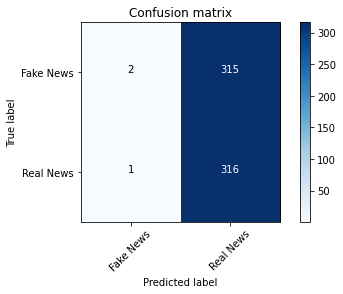

In [101]:
predictions = passive_agressive.predict(X_additional_test)

model_report(passive_agressive, X_additional_test, y_additional_test)

## Conclusion

In this notebook we gathered and cleaned our data, implemented a model, compared it with other models and tested it on different data. Here we learned a lot of new terminologies and how to implement them with code. I hope you liked and enjoyed this notebook.

## References

Project idea: [https://www.upgrad.com/blog/data-science-project-ideas-topics-beginners/#12_Fake_News_Detection](https://www.upgrad.com/blog/data-science-project-ideas-topics-beginners/#12_Fake_News_Detection)

Initial implementation: [https://www.analyticsvidhya.com/blog/2021/07/detecting-fake-news-with-natural-language-processing/#h2_3?&utm_source=coding-window-blog&source=coding-window-blog](https://www.analyticsvidhya.com/blog/2021/07/detecting-fake-news-with-natural-language-processing/#h2_3?&utm_source=coding-window-blog&source=coding-window-blog)

Train/Test data source: [https://www.kaggle.com/c/fake-news/data](https://www.kaggle.com/c/fake-news/data)

Additional data source: [https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news](https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news)

In [105]:
mlp = MLPClassifier()

mlp.fit(X_train, y_train)

MLPClassifier()

99.32367149758454
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1039
           1       0.99      1.00      0.99      1031

    accuracy                           0.99      2070
   macro avg       0.99      0.99      0.99      2070
weighted avg       0.99      0.99      0.99      2070

Confusion matrix, without normalization


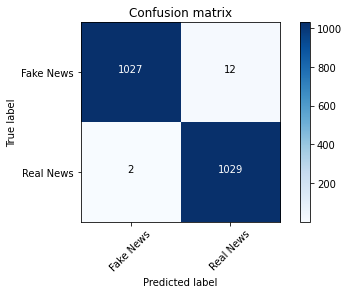

50.473186119873816
              precision    recall  f1-score   support

           0       0.71      0.02      0.03       317
           1       0.50      0.99      0.67       317

    accuracy                           0.50       634
   macro avg       0.61      0.50      0.35       634
weighted avg       0.61      0.50      0.35       634

Confusion matrix, without normalization


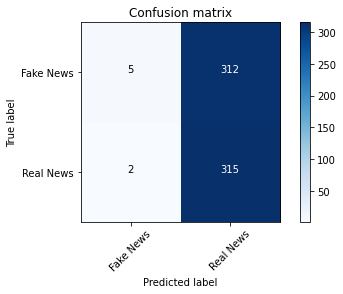

In [106]:
model_report(mlp, X_test, y_test)

plt.show()

model_report(mlp, X_additional_test, y_additional_test)